In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# load data 
date_times = [
    "Date", "Booking Date",
    "Actual Room In DateTime",
    "Actual Room Out DateTime"
]
data = pd.read_excel("../Data/UVM_OR_DATA.xlsx", parse_dates=date_times)

# select variables
var_list = [
    "Case", "Date", "Booking Date", "Room", "Primary Department",
    "Patient Type", "Elective", "Add on", "Actual Room In DateTime",
    "Actual Room Out DateTime"
]
data = data[var_list]
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" ", "_")

# extract surgery date, month and weekend indicator
data["Surgery_Date"] = pd.to_datetime(data["Actual_Room_In_DateTime"].dt.date)
data["Actual_Month"] = data['Surgery_Date'].dt.strftime('%b')
data["Weekend"] = data['Surgery_Date'].dt.strftime('%a')
data["Weekend"] = np.where(
    data["Weekend"].isna(), np.nan,
    np.where(
        data["Weekend"].isin(["Sat", "Sun"]), 1, 0
    )
)

policy_date = pd.to_datetime("May 1, 2019")
compared_month = ["May", "Jun", "Jul", "Aug", "Sep", "Oct"]
month_order = ["May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]

# calculate waiting times
data["Actual_Wait"] = [x.days for x in data["Surgery_Date"] - data["Booking_Date"]]

# assign treatment and control group, pre- and post-intervention period
# release_0 = ["Acute Care Service", "Ortho Trauma", "Cardiothoracic"]
# release_72 = ["Ortho Hand"]
nonadopter = ["Acute Care Service", "Ortho Trauma", "Cardiothoracic", "Ortho Hand"]
data["Intervention"] = np.where(
    data["Primary_Department"].isna(), np.nan,
    np.where(
        data["Primary_Department"].isin(nonadopter), 0, 1
    )
)
data["Period"] = np.where(data["Booking_Date"]>= policy_date, 1, 0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22286 entries, 0 to 22285
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Case                      22286 non-null  object        
 1   Date                      22286 non-null  datetime64[ns]
 2   Booking_Date              22286 non-null  datetime64[ns]
 3   Room                      22286 non-null  object        
 4   Primary_Department        22146 non-null  object        
 5   Patient_Type              22279 non-null  object        
 6   Elective                  21981 non-null  object        
 7   Add_on                    22286 non-null  object        
 8   Actual_Room_In_DateTime   22073 non-null  datetime64[ns]
 9   Actual_Room_Out_DateTime  22073 non-null  datetime64[ns]
 10  Surgery_Date              22073 non-null  datetime64[ns]
 11  Actual_Month              22073 non-null  object        
 12  Weekend           

# Parallel Trend

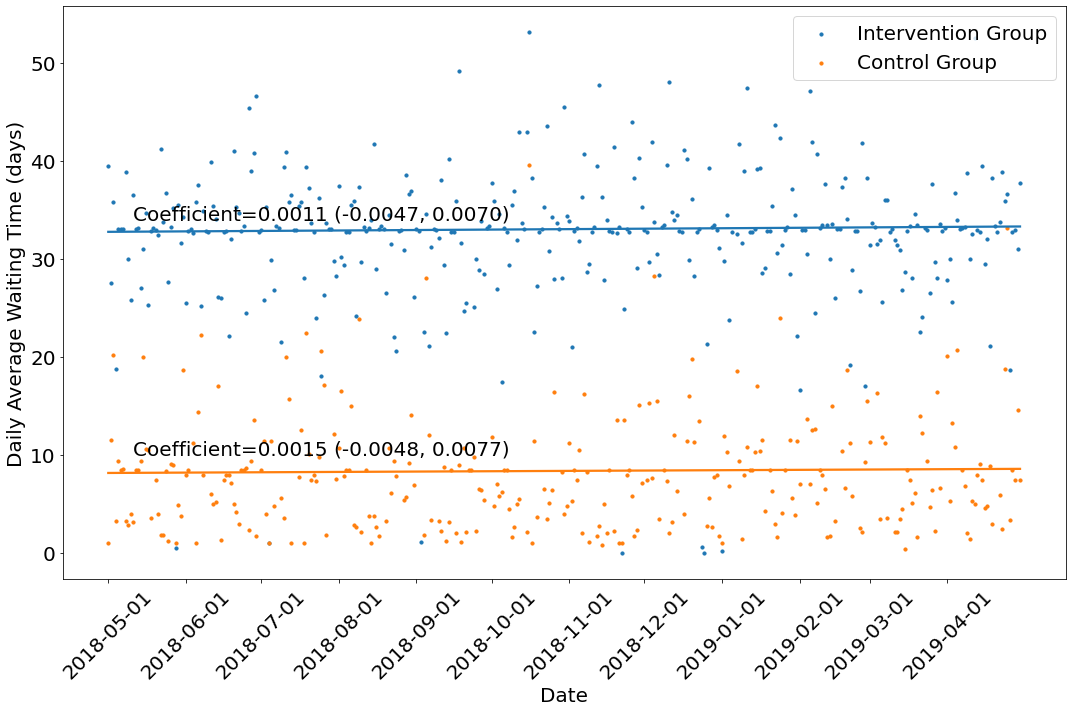

In [4]:
date_upper_limit = pd.to_datetime("2019-05-01")
date_lower_limit = pd.to_datetime("2018-05-01")

xticklabels = pd.date_range(date_lower_limit, date_upper_limit, freq="MS", inclusive="left")
xticks = [x.days for x in xticklabels-date_lower_limit]
xticklabels = [x.date() for x in xticklabels]

parallel_data = data[
    (data["Surgery_Date"]<date_upper_limit) &
    (data["Surgery_Date"]>=date_lower_limit)
][["Surgery_Date", "Actual_Wait", "Intervention", "Weekend"]].copy()
parallel_data.dropna(inplace=True)
parallel_data["x_date"] = [x.days for x in parallel_data["Surgery_Date"]-date_lower_limit]

model1 = sm.OLS(
    parallel_data[parallel_data["Intervention"]==0]["Actual_Wait"],
    sm.add_constant(parallel_data[parallel_data["Intervention"]==0][["x_date", "Weekend"]])
)
result1 = model1.fit(cov_type="HC1")
theta1 = result1.params

model2 = sm.OLS(
    parallel_data[parallel_data["Intervention"]==1]["Actual_Wait"],
    sm.add_constant(parallel_data[parallel_data["Intervention"]==1][["x_date", "Weekend"]])
)
result2 = model2.fit(cov_type="HC1")
theta2 = result2.params

parallel_data["Actual_Wait"] = parallel_data["Actual_Wait"] - parallel_data["Weekend"]*(theta1[2]*(1-parallel_data["Intervention"]) + theta2[2]*parallel_data["Intervention"])

plt.figure(figsize=(15, 10))
ax = plt.axes()

sns.regplot(
    x="x_date",
    y="Actual_Wait",
    x_estimator=np.mean,
    data=parallel_data[parallel_data["Intervention"]==1],
    scatter_kws={"s": 10},
    ci=None,
    label="Intervention Group"
)

sns.regplot(
    x="x_date",
    y="Actual_Wait",
    x_estimator=np.mean,
    data=parallel_data[parallel_data["Intervention"]==0],
    scatter_kws={"s": 10},
    ci=None,
    label="Control Group"
)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("Date", fontsize=20)
plt.ylabel("Daily Average Waiting Time (days)", fontsize=20)
plt.legend(loc="upper right", fontsize=20)

plt.text(10, 34, 
         "Coefficient=%.4f (%.4f, %.4f)" %(theta1[1], result1.conf_int().loc["x_date", 0], result1.conf_int().loc["x_date", 1]),
         fontsize=20)
plt.text(10, 10,
         "Coefficient=%.4f (%.4f, %.4f)" %(theta2[1], result2.conf_int().loc["x_date", 0], result2.conf_int().loc["x_date", 1]), 
         fontsize=20)

plt.tight_layout()
plt.savefig("../Figures/Parallel_Trend_Wait.pdf")
plt.show()

In [5]:
parallel_data = data[
    (data["Surgery_Date"]<date_upper_limit) &
    (data["Surgery_Date"]>=date_lower_limit)
][["Intervention", "Actual_Wait", "Elective",
   "Patient_Type", "Weekend", "Surgery_Date"]].copy()
parallel_data.dropna(inplace=True)
parallel_data["x_date"] = [x.days for x in parallel_data["Surgery_Date"]-date_lower_limit]
parallel_data.drop("Surgery_Date", axis=1, inplace=True)
parallel_data["Patient_Type"] = np.where(parallel_data["Patient_Type"]=="Inpatient", 1, 0)
parallel_data["Elective"] = np.where(
    parallel_data["Elective"]=="Yes", 1,
    np.where(
        parallel_data["Elective"]=="No", 0, np.nan
    )
)

parallel_data['DID'] = parallel_data['Intervention']*parallel_data["x_date"]
parallel_data["const"] = 1

model = sm.OLS(parallel_data["Actual_Wait"],
               parallel_data.drop("Actual_Wait", axis=1))
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Actual_Wait   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     884.3
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:26:39   Log-Likelihood:                -61379.
No. Observations:               12534   AIC:                         1.228e+05
Df Residuals:                   12527   BIC:                         1.228e+05
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intervention    21.5870      0.990     21.805   

In [6]:
parallel_data = data[
    (data["Surgery_Date"]<date_upper_limit) &
    (data["Surgery_Date"]>=date_lower_limit)
][["Intervention", "Actual_Wait", "Elective",
   "Patient_Type", "Weekend", "Actual_Month"]].copy()
parallel_data.dropna(inplace=True)
parallel_data["Patient_Type"] = np.where(parallel_data["Patient_Type"]=="Inpatient", 1, 0)
parallel_data["Elective"] = np.where(parallel_data["Elective"]=="Yes", 1, 0)
dummy = pd.get_dummies(parallel_data["Actual_Month"])
dummy.drop("May", axis=1, inplace=True)
parallel_data = pd.concat([parallel_data, dummy], axis=1)
parallel_data.drop("Actual_Month", axis=1, inplace=True)

for var in month_order[1:]:
    parallel_data['DID_'+var] = parallel_data['Intervention']*parallel_data[var]
parallel_data["const"] = 1

model = sm.OLS(parallel_data["Actual_Wait"],
               parallel_data.drop("Actual_Wait", axis=1))
results = model.fit(cov_type="HC1")
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Actual_Wait   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     205.7
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:26:39   Log-Likelihood:                -61369.
No. Observations:               12534   AIC:                         1.228e+05
Df Residuals:                   12507   BIC:                         1.230e+05
Df Model:                          26                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intervention    21.4779      1.504     14.282   

# Base Analysis

In [7]:
# select cases performed in Aug, Sep, and Oct
# remove the cases scheduled before May 1
data_base = data[data["Actual_Month"].isin(["Aug", "Sep", "Oct"])].copy()
data_base["Ambiguity"] = np.where(
    data_base["Surgery_Date"]>=policy_date,
    policy_date,
    pd.to_datetime("2018-05-01")
)
data_base = data_base[data_base["Booking_Date"]>=data_base["Ambiguity"]]
data_base.drop("Ambiguity", axis=1, inplace=True)

data_base.drop(
    ["Case", "Date", "Booking_Date", "Room", "Primary_Department",
     "Actual_Room_In_DateTime", "Actual_Room_Out_DateTime",
     "Surgery_Date"], axis=1, inplace=True
)
data_base.dropna(inplace=True)
data_base["Patient_Type"] = np.where(data_base["Patient_Type"]=="Inpatient", 1, 0)
data_base["Elective"] = np.where(data_base["Elective"]=="Yes", 1, 0)
data_base['Add_on'] = np.where(data_base["Add_on"]=="Yes", 1, 0)

dummy = pd.get_dummies(data_base["Actual_Month"])
dummy.drop("Aug", axis=1, inplace=True)
data_base = pd.concat([data_base, dummy], axis=1)
data_base.drop("Actual_Month", axis=1, inplace=True)

data_base['DID_7d'] = data_base['Intervention']*data_base["Period"]
data_base["const"] = 1

model = sm.OLS(data_base["Actual_Wait"], data_base.drop(["Actual_Wait"], axis=1))
results = model.fit(cov_type="HC1")
print(results.summary())

# Wald test
print()
print("="*90)
print("Wald test: Period + DID = 0")
Wald = results.wald_test("Period + DID_7d = 0", scalar=True)
print(Wald)

                            OLS Regression Results                            
Dep. Variable:            Actual_Wait   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     792.3
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:26:39   Log-Likelihood:                -39746.
No. Observations:                8468   AIC:                         7.951e+04
Df Residuals:                    8458   BIC:                         7.958e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Patient_Type    -1.5301      0.744     -2.057   

# Sensitivity Analysis

## 4-month Data

In [8]:
data_SA1 = data[data["Actual_Month"].isin(["Jul", "Aug", "Sep", "Oct"])].copy()
data_SA1["Ambiguity"] = np.where(
    data_SA1["Surgery_Date"]>=policy_date,
    policy_date,
    pd.to_datetime("2018-05-01")
)
data_SA1 = data_SA1[data_SA1["Booking_Date"]>=data_SA1["Ambiguity"]]
data_SA1.drop("Ambiguity", axis=1, inplace=True)

data_SA1.drop(
    ["Case", "Date", "Booking_Date", "Room", "Primary_Department",
     "Actual_Room_In_DateTime", "Actual_Room_Out_DateTime",
     "Surgery_Date"], axis=1, inplace=True
)
data_SA1.dropna(inplace=True)
data_SA1["Patient_Type"] = np.where(data_SA1["Patient_Type"]=="Inpatient", 1, 0)
data_SA1["Elective"] = np.where(data_SA1["Elective"]=="Yes", 1, 0)
data_SA1['Add_on'] = np.where(data_SA1["Add_on"]=="Yes", 1, 0)

dummy = pd.get_dummies(data_SA1["Actual_Month"])
dummy.drop("Aug", axis=1, inplace=True)
data_SA1 = pd.concat([data_SA1, dummy], axis=1)
data_SA1.drop("Actual_Month", axis=1, inplace=True)

data_SA1['DID_7d'] = data_SA1['Intervention']*data_SA1["Period"]
data_SA1["const"] = 1

model = sm.OLS(data_SA1["Actual_Wait"], data_SA1.drop(["Actual_Wait"], axis=1))
results = model.fit(cov_type="HC1")
print(results.summary())

# # Wald test
# print()
# print("="*90)
# print("Wald test: Period + DID = 0")
# Wald = results.wald_test("Period + DID_7d = 0", scalar=True)
# print(Wald)

                            OLS Regression Results                            
Dep. Variable:            Actual_Wait   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     899.9
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:26:39   Log-Likelihood:                -48116.
No. Observations:               10368   AIC:                         9.625e+04
Df Residuals:                   10357   BIC:                         9.633e+04
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Patient_Type    -1.5936      0.641     -2.485   

## Exclude Cases from Some Deps and ORs

In [9]:
data_SA2 = data[data["Actual_Month"].isin(["Aug", "Sep", "Oct"])].copy()
data_SA2["Ambiguity"] = np.where(
    data_SA2["Surgery_Date"]>=policy_date,
    policy_date,
    pd.to_datetime("2018-05-01")
)
data_SA2 = data_SA2[data_SA2["Booking_Date"]>=data_SA2["Ambiguity"]]
data_SA2.drop("Ambiguity", axis=1, inplace=True)

dep_before = set(data[data["Surgery_Date"]<policy_date]["Primary_Department"].unique())
dep_after = set(data[data["Surgery_Date"]>=policy_date]["Primary_Department"].unique())
deps = dep_before.intersection(dep_after)
deps = [x for x in deps if x==x]

room_before = data[data["Surgery_Date"]<policy_date]["Room"].unique()
room_after = data[data["Surgery_Date"]>=policy_date]["Room"].unique()
rooms = set(room_after).intersection(room_before)

data_SA2 = data_SA2[data_SA2["Primary_Department"].isin(deps)]
data_SA2 = data_SA2[data_SA2["Room"].isin(rooms)]
data_SA2.reset_index(drop=True, inplace=True)

data_SA2.drop(
    ["Case", "Date", "Booking_Date", "Room", "Primary_Department",
     "Actual_Room_In_DateTime", "Actual_Room_Out_DateTime",
     "Surgery_Date"], axis=1, inplace=True
)

data_SA2.dropna(inplace=True)
data_SA2["Patient_Type"] = np.where(data_SA2["Patient_Type"]=="Inpatient", 1, 0)
data_SA2["Elective"] = np.where(data_SA2["Elective"]=="Yes", 1, 0)
data_SA2['Add_on'] = np.where(data_SA2["Add_on"]=="Yes", 1, 0)

dummy = pd.get_dummies(data_SA2["Actual_Month"])
dummy.drop("Aug", axis=1, inplace=True)
data_SA2 = pd.concat([data_SA2, dummy], axis=1)
data_SA2.drop("Actual_Month", axis=1, inplace=True)

data_SA2['DID_7d'] = data_SA2['Intervention']*data_SA2["Period"]
data_SA2["const"] = 1

model = sm.OLS(data_SA2["Actual_Wait"], data_SA2.drop(["Actual_Wait"], axis=1))
results = model.fit(cov_type="HC1")
print(results.summary())

# # Wald test
# print()
# print("="*90)
# print("Wald test: Period + DID = 0")
# Wald = results.wald_test("Period + DID_7d = 0", scalar=True)
# print(Wald)

                            OLS Regression Results                            
Dep. Variable:            Actual_Wait   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     569.9
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:26:39   Log-Likelihood:                -29105.
No. Observations:                6229   AIC:                         5.823e+04
Df Residuals:                    6219   BIC:                         5.830e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Patient_Type     1.0312      0.886      1.164   

## Left-censor Construction

In [10]:
data_SA3 = data.copy()
data_SA3["Period"] = np.where(
    (((data_SA3["Booking_Date"]>=pd.to_datetime("May 1, 2018")) &
      (data_SA3["Actual_Month"]=="Aug")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Jun 1, 2018")) &
      (data_SA3["Actual_Month"]=="Sep")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Jul 1, 2018")) &
      (data_SA3["Actual_Month"]=="Oct")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Aug 1, 2018")) &
      (data_SA3["Actual_Month"]=="Nov")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Sep 1, 2018")) &
      (data_SA3["Actual_Month"]=="Dec")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Oct 1, 2018")) &
      (data_SA3["Actual_Month"]=="Jan")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Nov 1, 2018")) &
      (data_SA3["Actual_Month"]=="Feb")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Dec 1, 2018")) &
      (data_SA3["Actual_Month"]=="Mar")) |
     ((data_SA3["Booking_Date"]>=pd.to_datetime("Jan 1, 2019")) &
      (data_SA3["Actual_Month"]=="Apr"))) &
    (data_SA3["Surgery_Date"]<policy_date), 0,
    np.where(
        (((data_SA3["Booking_Date"]>=pd.to_datetime("May 1, 2019")) &
          (data_SA3["Actual_Month"]=="Aug")) |
         ((data_SA3["Booking_Date"]>=pd.to_datetime("Jun 1, 2019")) &
          (data_SA3["Actual_Month"]=="Sep")) |
         ((data_SA3["Booking_Date"]>=pd.to_datetime("Jul 1, 2019")) &
          (data_SA3["Actual_Month"]=="Oct"))) &
        (data_SA3["Surgery_Date"]>=policy_date), 1, np.nan
    )
)

data_SA3.drop(
    ["Case", "Date", "Booking_Date", "Room", "Primary_Department",
     "Actual_Room_In_DateTime", "Actual_Room_Out_DateTime",
     "Surgery_Date"], axis=1, inplace=True
)

data_SA3.dropna(inplace=True)
data_SA3["Patient_Type"] = np.where(data_SA3["Patient_Type"]=="Inpatient", 1, 0)
data_SA3["Elective"] = np.where(data_SA3["Elective"]=="Yes", 1, 0)
data_SA3['Add_on'] = np.where(data_SA3["Add_on"]=="Yes", 1, 0)

data_SA3.drop("Actual_Month", axis=1, inplace=True)

data_SA3['DID_7d'] = data_SA3['Intervention']*data_SA3["Period"]
data_SA3["const"] = 1

model = sm.OLS(data_SA3["Actual_Wait"], data_SA3.drop(["Actual_Wait"], axis=1))
results = model.fit(cov_type="HC1")
print(results.summary())

# # Wald test
# print()
# print("="*90)
# print("Wald test: Period + DID = 0")
# Wald = results.wald_test("Period + DID_7d = 0", scalar=True)
# print(Wald)

                            OLS Regression Results                            
Dep. Variable:            Actual_Wait   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     1977.
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:26:40   Log-Likelihood:                -63649.
No. Observations:               14154   AIC:                         1.273e+05
Df Residuals:                   14146   BIC:                         1.274e+05
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Patient_Type    -2.6461      0.467     -5.663   

## Log Transformation

In [11]:
model = sm.OLS(np.log(data_base["Actual_Wait"]+1), data_base.drop(["Actual_Wait"], axis=1))
results = model.fit(cov_type="HC1")
print(results.summary())

# # Wald test
# print()
# print("="*90)
# print("Wald test: Period + DID = 0")
# Wald = results.wald_test("Period + DID_7d = 0", scalar=True)
# print(Wald)

                            OLS Regression Results                            
Dep. Variable:            Actual_Wait   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     3902.
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        00:26:40   Log-Likelihood:                -11047.
No. Observations:                8468   AIC:                         2.211e+04
Df Residuals:                    8458   BIC:                         2.218e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Patient_Type    -0.2616      0.026    -10.006   